In [1]:
import numpy as np
import gdal
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#merged slope raster, accumulation area raster, and watershed raster into one three band raster.
# exported this raster into a text file from OSGeo4W command line:
# gdal2xyz input.tif -band 1 -band 2 -band 3 output.txt. This is a slow operation... 

#Dry = 4
#Hank = 3
#Elder = 1
#Fox = 2

In [3]:
ds = gdal.Open('..\..\GIS\LIDAR\merge3.tif')
#Band 1 = area
#Band 2 = slope
# Band 3 = watershed

In [4]:
band1 = ds.GetRasterBand(1)
band2 = ds.GetRasterBand(2)
band3 = ds.GetRasterBand(3)

In [8]:
array1 = band1.ReadAsArray().flatten()
array2 = band2.ReadAsArray().flatten()
array3 = band3.ReadAsArray().flatten()

In [29]:
elderSlope = array2[array3 == 1]
elderArea = array1[array3 == 1]
hankSlope = array2[array3 == 3]
hankArea = array1[array3 == 3]



In [31]:
elderArea = elderArea + 1 #can't take log of 0
hankArea = hankArea + 1 #can't take log of 0


In [32]:
#GENERATE LOGARITHMIC BIN SPACING
numBins = 40

area_bins_elder = np.logspace(np.log10(min(elderArea)), np.log10(max(elderArea)), numBins)

area_bins_hank = np.logspace(np.log10(min(hankArea)), np.log10(max(hankArea)), numBins)


In [33]:
#Return the indices_elder of the bins to which each value in input array belongs.
indices_elder = np.digitize(elderArea, area_bins_elder)
indices_hank = np.digitize(hankArea, area_bins_hank)



In [34]:
#COMPUTE MEAN, MEDIAN AND STANDARD DEVIATION OF SLOPE IN EACH AREA BIN
bin_means_elder = [elderSlope[indices_elder == i].mean() for i in range(1, len(area_bins_elder))]
bin_medians_elder = [np.median(elderSlope[indices_elder == i]) for i in range(1, len(area_bins_elder))]
bin_stds_elder = [elderSlope[indices_elder == i].std() for i in range(1, len(area_bins_elder))]

bin_means_hank = [hankSlope[indices_hank == i].mean() for i in range(1, len(area_bins_hank))]
bin_medians_hank = [np.median(hankSlope[indices_hank == i]) for i in range(1, len(area_bins_hank))]
bin_stds_hank = [hankSlope[indices_hank == i].std() for i in range(1, len(area_bins_hank))]



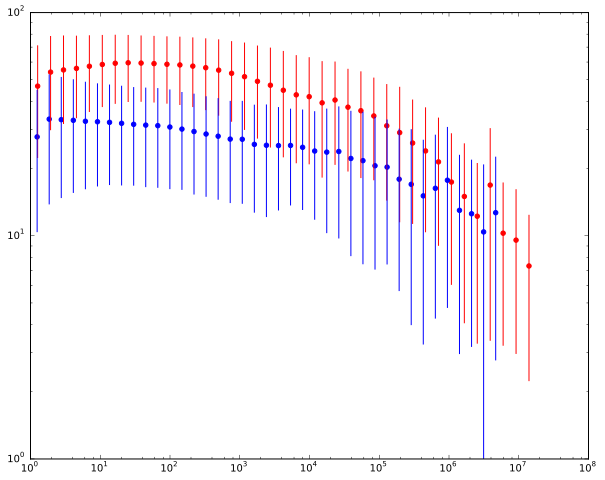

In [35]:
# Create a figure
plt.figure(figsize=(10,8))

plt.scatter(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),bin_means_elder, marker = "o", color = 'r')
plt.errorbar(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),bin_means_elder, yerr=bin_stds_elder, fmt = None, capthick=0, ecolor = 'r')

plt.scatter(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),bin_means_hank, marker = "o", color = 'b')
plt.errorbar(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),bin_means_hank, yerr=bin_stds_hank, fmt = None, capthick=0, ecolor = 'b')


plt.yscale('log')
plt.xscale('log')
plt.show()